# Introduction

# Equations

# Numerical Methods

In [1]:
#EAS 4610 proj
#crank-nicolson method 

# import packages
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import os
import math
from scipy.sparse import spdiags
#import xarray as xr

In [2]:
# PARAMETERS 

k = 2 #m/d   hydraulic conductivity
n = 0.2  #effective porosity
S = 1e-6  #storage coeff
H = 45  #m #thickness of the aquifer
zb = -45 #m #bottom of aquifer
zt = 0 #m #top of aquifer
L = 1000 #m #length of the cross section
W = 1 #m #width of cross-section normal to the plane of flow
vs = 0.025 #dimensionless density
# ditch is located 590 m from the coastline at x = 0
h0 = 0.05 #m
N = 0 #infiltration of freshwater

tau = k*vs*(zt-zb)
T = k*(zt-zb)



# BOUNDARY CONDITIONS

Q0 = 0.1 #m**2/d - outflow, uniform flow towards the coast
Q0p = 0.05 #m**2/d - outflow when water is pumped from the ditch
zeta0 = -Q0/(k*vs) #m - boundary condition at the coast - top 
zeta0p = -Q0p/(k*vs) 
# at x=0, h0 = 0.05 m and zeta0 = -2 m
# at t=0, Q = -0.05 m**2/d
zetaf = -h0/vs  #steady state condition, end of simulation



# DISCRETIZING

x = np.linspace(0,L,L+1)
dx = 10 #m
t = np.linspace(0,36500,200)
dt = 183  #half a year in days

#courant number 
D = 1
CDz = tau*dt/(n*dx**2)
CDh = T*dt/(S*dx**2) #rename to S, currently D as fake storage coeff

#n should be the length of the spatial dimension
#n = len(x)


<ipython-input-3-0cc9d30eaa61>:40: RuntimeWarning: overflow encountered in matmul
  zetai1[:,i+1] = A@zeta[:,i] + B@hi1[:,i+1] #+ dt/n
<ipython-input-3-0cc9d30eaa61>:39: RuntimeWarning: overflow encountered in matmul
  hi1[:,i+1] = M@hmat[:,i] + M2@zetai1[:,i] #+ N
<ipython-input-3-0cc9d30eaa61>:39: RuntimeWarning: invalid value encountered in matmul
  hi1[:,i+1] = M@hmat[:,i] + M2@zetai1[:,i] #+ N


[[-2.00000000e+00 -2.00000000e+00 -2.00000000e+00 ... -2.00000000e+00
  -2.00000000e+00 -2.00000000e+00]
 [ 0.00000000e+00  1.69541313e+08  2.41163380e+19 ...             nan
              nan             nan]
 [ 0.00000000e+00 -6.77328754e+09 -9.87023577e+20 ...             nan
              nan             nan]
 ...
 [ 0.00000000e+00 -4.11750000e+01 -4.62972666e+14 ...             nan
              nan             nan]
 [ 0.00000000e+00  3.29200000e+03  4.62833049e+14 ...             nan
              nan             nan]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


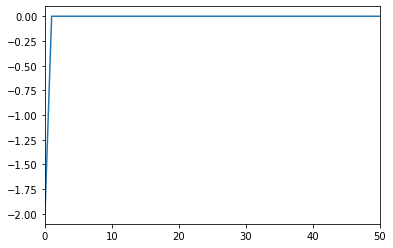

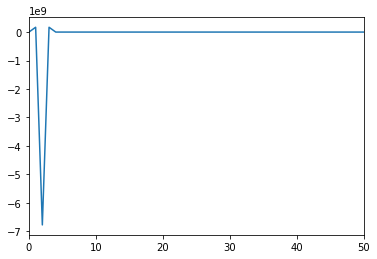

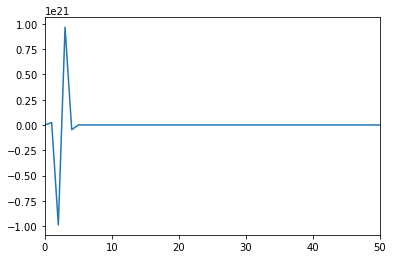

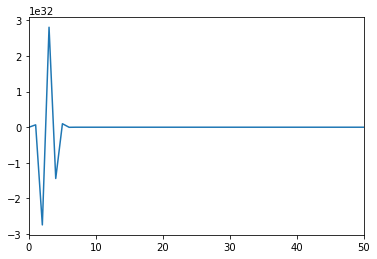

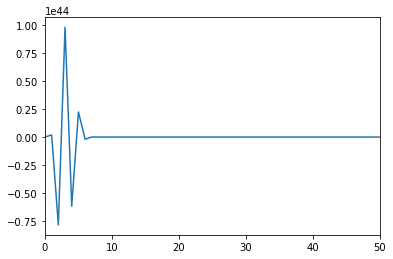

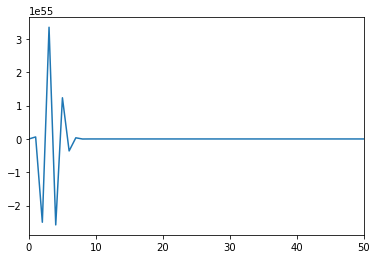

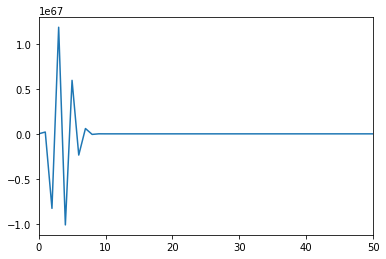

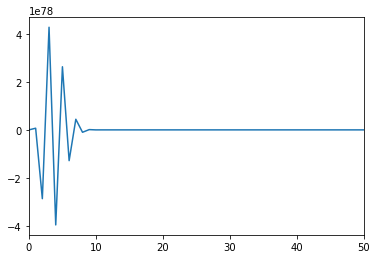

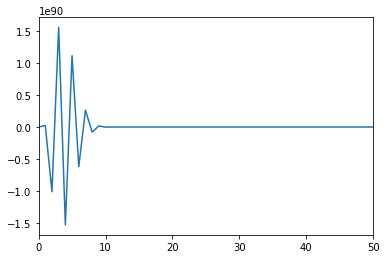

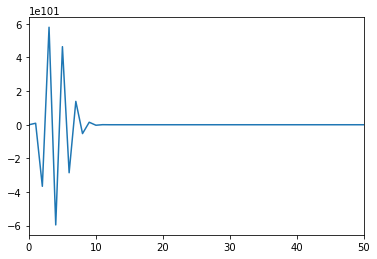

'   \nprint(np.size(zetai1))\nprint(np.size(zeta))\nprint(len(zetai1))\nprint(len(zetai1[0]))\nprint(zetai1)\n\n#creating the known matrices\n#M**(k+1)\nbins = np.array([-1/2*Cd*np.ones(n),(1+Cd)*np.ones(n),-1/2*Cd*np.ones(n)])\ndiags = np.array([-1,0,1])\nM_k1 = spdiags(bins,diags,n,n).toarray()\n\n#M**k\nbins2 = np.array([1/2*Cd*np.ones(n),(1-Cd)*np.ones(n),1/2*Cd*np.ones(n)])\nM_k = spdiags(bins2,diags,n,n).toarray()\n\n#A\nA = np.ones(n,len(t))\nA[1,:] = zeta0_a\nA[-1,:] = zeta0_b\n'

In [3]:
#Making the Matrices/running the model
data1 = np.array([CDh*np.ones(L+1), (1-2*CDh)*np.ones(L+1), CDh*np.ones(L+1)])
diags1 = np.array([-1, 0, 1])
M = spdiags(data1, diags1,L-1,L-1).toarray()

data2 = np.array([CDh*np.ones(L+1), (1-CDh)*np.ones(L+1), CDh*np.ones(L+1)])
diags2 = np.array([-1, 0, 1])
M2 = spdiags(data2, diags2,L-1,L-1).toarray()

data3 = np.array([CDz*np.ones(L+1), (1-2*CDz/vs)*np.ones(L+1), CDz*np.ones(L+1)])
diags3 = np.array([-1, 0, 1])
A = spdiags(data3, diags3,L-1,L-1).toarray()

data4 = np.array([CDz*np.ones(L+1), (1-CDz/vs)*np.ones(L+1), CDz*np.ones(L+1)])
diags4 = np.array([-1, 0, 1])
B = spdiags(data4, diags4,L-1,L-1).toarray()

M2[0,:] = 0
M[0,:] = 0
M[0,0] = 1

hi1 = np.zeros((L-1,200))
zetai1 = np.zeros((L-1,200))
zeta = np.zeros((L-1,200))  #given values matrix for zeta
hmat = np.zeros((L-1,200))  #given values matrix for h


#hi1[:,0] = 10 ##CHANGE THIS VALUE, JUST A PLACEHOLDER, INITIAL CONDITION HERE
hmat[0,:] = h0
zeta[0,:] = zeta0
zeta[-1,:] = zetaf

#print(len(zeta))
#print(len(zeta[0]))


#print((hmat))
for i in range(0,len(t)-1):
    hi1[:,i+1] = M@hmat[:,i] + M2@zetai1[:,i] #+ N
    zetai1[:,i+1] = A@zeta[:,i] + B@hi1[:,i+1] #+ dt/n
    
 #   hi1[:,i+1] = np.matmul(M,hmat[:,i]) + np.matmul(M2,zetai1[:,i]) #+ N
  #  zetai1[:,i+1] = np.matmul(A,zeta[:,i]) + np.matmul(B,hi1[:,i+1]) #+ dt/n
  #  zetai1[:,i+1] = np.linalg.inv(hi1)@(hi@zetai1[:,i]+(0.5*CD)*zeta[:,i]-(-0.5*CD)*zeta[:,i+1])
  #  hi1[:,i+1] = np.linalg.inv(zetai1)@(zetai@hi1[:,i]+(0.5*CD)*hmat[:,i]-(-0.5*CD)*hmat[:,i+1])

Mf = np.zeros((L+1,200))   #final matrix
Mf[0,:] = zeta[0,:]
Mf[1:-1] = zetai1[0:,:]
#Mf[-1,:] = zeta[-1,:]

'''
print(Mf)
print(hi1) 
print("Zetai1")
print(zetai1)
'''
print(Mf)

z = np.linspace(-45,0,200)
#print(Mf[0:55])
#plt.contourf(x[0:20],z,np.transpose(Mf[0:20]))
#plt.ylim(-45,-38)
#plt.colorbar()


for l in range(0,10):
    plt.plot(x,Mf[:,l])
#plt.ylim(0,5)
    plt.xlim(0,50)
    plt.show()

#print(zetai1)

'''   
print(np.size(zetai1))
print(np.size(zeta))
print(len(zetai1))
print(len(zetai1[0]))
print(zetai1)

#creating the known matrices
#M**(k+1)
bins = np.array([-1/2*Cd*np.ones(n),(1+Cd)*np.ones(n),-1/2*Cd*np.ones(n)])
diags = np.array([-1,0,1])
M_k1 = spdiags(bins,diags,n,n).toarray()

#M**k
bins2 = np.array([1/2*Cd*np.ones(n),(1-Cd)*np.ones(n),1/2*Cd*np.ones(n)])
M_k = spdiags(bins2,diags,n,n).toarray()

#A
A = np.ones(n,len(t))
A[1,:] = zeta0_a
A[-1,:] = zeta0_b
'''

### Results

# Figures 

# Video Walkthrough

# References
Bakker, M. (1970, January 1). Simple groundwater flow models for seawater intrusion: Semantic scholar. undefined. Retrieved November 27, 2022, from https://www.semanticscholar.org/paper/SIMPLE-GROUNDWATER-FLOW-MODELS-FOR-SEAWATER-Bakker/1ac46ef8707dda37496dd907e3dc9e3b0d52c4bc 